In [16]:
from robust_adaptive_loss import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

%matplotlib inline

Vector = np.ndarray

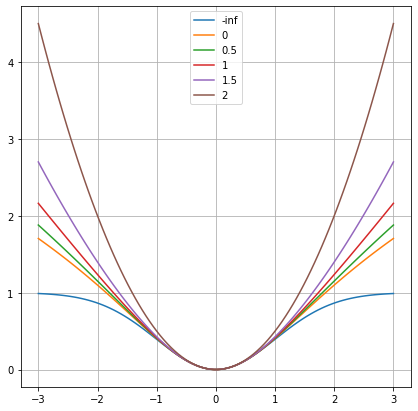

In [17]:
fig, ax = plt.subplots(figsize=(7,7))
x = np.linspace(-3,3,100)
ax.grid()
for alpha in [-np.inf, 0, 0.5, 1, 1.5, 2]:
    ax.plot(x,rho(x,alpha,1), label=alpha)
ax.legend()
plt.show()

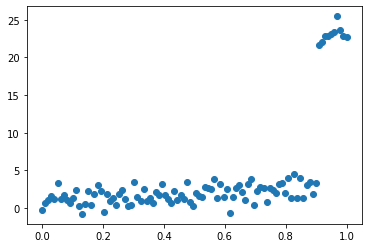

In [27]:
n = 100
n_bad = 10
shift_bad = 20
sigma = 1
X = np.ones(n)
X = np.column_stack([X, np.linspace(0, 1, n)])
np.random.seed(33)

_beta = np.random.uniform(1,2,2)
_beta

y = X.dot(_beta) + np.random.normal(0,sigma,n)
y[-n_bad:] = y[-n_bad:] + shift_bad
plt.scatter(X[:,1],y)

In [28]:
def objective_generator(x: np.ndarray, 
                        y: Vector, 
                        c: float=1, 
                        redundant: bool=False, 
                        with_control: bool=True,
                        approx_control: bool=True) -> Callable[[Vector], float]:
    assert c > 0
    assert x.shape[0] == y.shape[0]
    assert y.shape[0] == y.size

    def redundant_objective(pars: np.ndarray) -> float:
        k = pars.size - 1
        n = x.shape[0]
        assert k == x.shape[1]
        alpha = 2
        assert 0 <= alpha <= 2
        beta = pars[1:].reshape(k, 1)
        mu = x.dot(beta)
        e = y.reshape(n,1) - mu
        loss = rho(e, alpha, c).sum() # + n*np.log(z(alpha)[0])
        return loss
    
    def objective(pars: np.ndarray) -> float:
        k = pars.size - 1
        n = x.shape[0]
        assert k == x.shape[1]
        alpha = pars[0]
        beta = pars[1:].reshape(k, 1)
        mu = x.dot(beta)
        e = y.reshape(n,1) - mu
        loss = rho(e, alpha, c).sum()
        if with_control:
            if approx_control:
                loss -= n*np.log(curve(alpha))
            else:
                loss += n*np.log(z(alpha))
        return loss / n
    
    if redundant:
        return redundant_objective
    else:
        return objective


In [29]:
f = objective_generator(X, y, with_control=False)
alphas = np.linspace(0,5,100)
losses = []
zs = []
for a in alphas:
    losses.append(f(np.array([a, _beta[0], _beta[1]])))
    zs.append(curve(a))
losses = np.array(losses)
zs = np.array(zs)


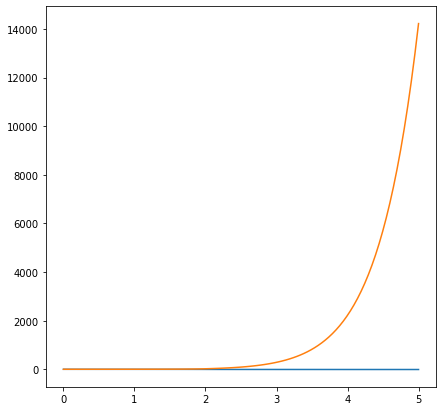

In [30]:
fig, ax = plt.subplots(figsize=(7,7))
ax.plot(alphas, -zs)
ax.plot(alphas, losses)
plt.show()

In [31]:
f = objective_generator(X, y, 1)

In [32]:
opt = minimize(f, x0 = np.array([1,1,1]), method='L-BFGS-B', options={'maxfev':5000})
opt

<ipython-input-32-c3bce75310b3>:1: OptimizeWarning: Unknown solver options: maxfev
  opt = minimize(f, x0 = np.array([1,1,1]), method='L-BFGS-B', options={'maxfev':5000})


      fun: 1.7097724119431825
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.68887127e-04, -8.10684853e-05, -4.58078020e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 68
      nit: 15
   status: 0
  success: True
        x: array([0.66709562, 0.66061957, 2.86353417])

In [33]:
print(opt['x'][0])
print(opt['x'][1:])
print(_beta)

0.667095619655395
[0.66061957 2.86353417]
[1.24851013 1.44997542]


In [34]:
naive_beta = np.linalg.inv(X.T.dot(X)).dot(X.T.dot(y))

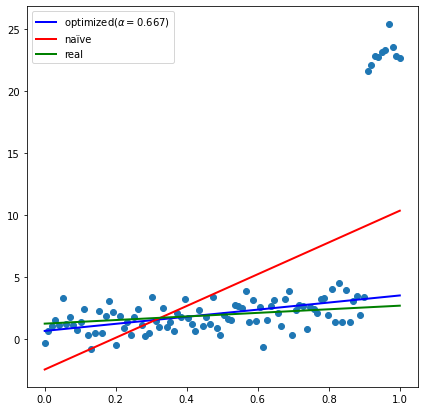

In [35]:
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(X[:,1],y)
alpha_opt = np.round(opt['x'][0],3)
ax.plot(X[:,1], X.dot(opt['x'][1:]), color='blue', linewidth=2, label=r'optimized($\alpha={}$)'.format(alpha_opt))
ax.plot(X[:,1], X.dot(naive_beta), color='red', linewidth=2, label='naïve')
ax.plot(X[:,1], X.dot(_beta), color='green', linewidth=2, label='real')
ax.legend()
plt.show()